# Importing Libraries and Loading Data

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin
from IPython.display import display
from sklearn.linear_model import (ElasticNetCV, LassoCV, RidgeCV, LinearRegression)
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, StackingRegressor)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import skew
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.metrics import confusion_matrix
import category_encoders as ce
import math
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import calinski_harabasz_score


%matplotlib inline

data = pd.read_csv("penguins_size.csv")

# Data Cleaning and Feature Engineering

## Adressing Missing Values

In [315]:
missing = data.loc[336,:].copy(deep=True)
missing.sex = np.nan
data.loc[336,:] = missing
data = data.drop([3,339])

## OneHotEncoding Categorical Variables

In [316]:
features_to_convert = ["island","sex"]
feature_def = gen_features(columns = [[col] for col in data.columns if col not in features_to_convert], 
                           classes = None)
feature_def_convert = gen_features(columns = [[col] for col in features_to_convert], 
                                   classes =[{'class': ce.OneHotEncoder, 
                                              'handle_unknown':'ignore'}])
mapper_onehot = DataFrameMapper(feature_def_convert + feature_def,df_out = True)
data = mapper_onehot.fit_transform(data)
data = data.drop(["sex_0_3"],axis=1)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [317]:
data['culmen_area_mm'] = data['culmen_length_mm'] * data['culmen_depth_mm']

## Extracting Labels

In [318]:
le = LabelEncoder()
labels = le.fit_transform(data.species)
target_names = dict(zip(range(3),le.classes_))

data = data.drop(['species'],axis=1)

## Build Pipeline

In [319]:
pca = Pipeline([('scaling', StandardScaler()),
                ('pca', PCA())])

# Model Testing

## Hyperparameter Optimization:

In [351]:
knn = KNeighborsClassifier(metric='euclidean')
rfc = RandomForestClassifier()
param_grid_knn = {'n_neighbors':[1,3,5,10], 'weights':['uniform','distance']}
param_grid_rfc = {'n_estimators':[1,10,50,100,150], }
estimator = GridSearchCV(rfc,param_grid=param_grid_rfc, cv=kfold,verbose=1)




estimator.fit(pca.fit_transform(data),labels)

print(f"Best Estimator: {estimator.best_estimator_}")
print(f"Best Score: {estimator.best_score_}")
print(f"Best Parameters: {estimator.best_params_}")
print(estimator.predict(X_test))


Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Estimator: RandomForestClassifier(n_estimators=10)
Best Score: 0.9882352941176471
Best Parameters: {'n_estimators': 10}
[2 0 0 0 0 2 1 1 2 0 0 2 2 2 0 1 0 0 1 0 1 0 2 0 0 0 0 1 0 2 1 0 0 2 0 0 1
 2 0 0 0 0 2 2 0 1 2 2 0 0 2 1 2 0 0 1 0 2 2 0 2 2 2 2 1 0 0 0 0 0 0 0 2 2
 2 0 2 1 2 0 0 2 0 2 0 0 0 2 0 1 2 2 2 2 1 1 0 1 0 1 0 0 2 0 2 2 1 2 2 1 0
 0 0]


## StackedClassifier

In [352]:
X_train, X_test, y_train, y_test = train_test_split(pca.fit_transform(data), labels, test_size=0.33, random_state=42)

kfold = KFold(n_splits = 10, shuffle=True, random_state=1)

knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
rfc = RandomForestClassifier(n_estimators=100)

estimator = StackingClassifier([('knn',knn),('rfc',rfc)],cv=kfold)
estimator.fit(X_train,y_train)

print(estimator.predict(X_test))

[2 0 0 0 0 2 1 1 2 0 0 2 2 2 0 1 0 0 1 0 1 0 2 0 0 0 0 1 0 2 1 0 0 2 0 0 1
 2 0 0 0 0 2 2 0 1 2 2 0 0 2 1 2 0 0 1 0 2 2 0 2 2 2 2 1 0 0 0 0 0 0 0 2 2
 2 0 2 1 2 0 0 2 0 2 0 0 0 2 0 1 2 2 2 2 1 1 0 1 0 1 0 0 2 0 2 2 1 2 2 1 0
 0 0]


## Unsupervised Learning

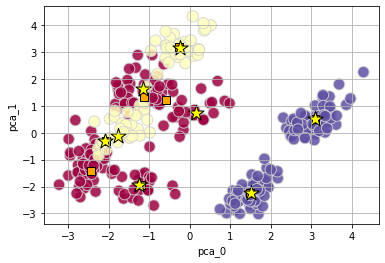

In [361]:
k_means = KMeans(n_clusters=8, init='k-means++',max_iter=999, n_init=10, random_state=101)
mb_k_means = MiniBatchKMeans(n_clusters=8, init='k-means++',max_iter=999, n_init=10, random_state=101)

pca_features = pca.fit_transform(data)

k_means.fit(pca_features)
mb_k_means.fit(pca_features)

plt.scatter(pca_features[:,0],pca_features[:,1],
           s=2**7,c=labels,edgecolors='lightgrey', alpha=0.85, cmap='Spectral')

plt.xlabel('pca_0')
plt.ylabel('pca_1')
plt.grid()

km_centers= k_means.cluster_centers_
mbkm_centers = mb_k_means.cluster_centers_

plt.scatter(km_centers[:,0], km_centers[:,1],
           s=2**6, marker ='s', c='orange',edgecolors='black')

plt.scatter(mbkm_centers[:,0], mbkm_centers[:,1],
           s=2**8, marker ='*', c='yellow',edgecolors='black')

# for class_no in range(0,3):
#     plt.annotate(target_names[class_no],
#                 (pca_features[labels==class_no, 0].mean(),
#                  pca_features[labels==class_no, 1].mean()),
#                  fontsize = 20)


cm = confusion_matrix(y_true = labels, y_pred=k_means.labels_)
print(cm)

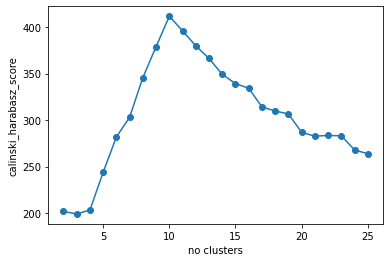

In [353]:

ch_scores = list()
max_clus = 25
for clus_no in range(2, max_clus+1):
    k_means = KMeans(n_clusters=clus_no, init='k-means++',max_iter=999, n_init=10, random_state=100)
    #k_means.fit(pca_features)
    k_means.fit(pca_features)
    ch = calinski_harabasz_score(pca_features, k_means.labels_)
    ch_scores.append(ch)
    
plt.plot(range(2,max_clus+1),ch_scores, 'o-')
plt.xlabel('no clusters')
plt.ylabel('calinski_harabasz_score')
plt.show()